In [1]:
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

plt.rcParams["mathtext.default"] = "regular"
path_to_results = Path("../../../results/rates")

In [2]:
def vmr_to_nd(vmr_gas, air_pressure, air_temperature):
    """Convert volume mixing ratio to number density [unitless to molecules cm-3]"""
    avogadro_const = 6.022 * 1e23  # [mol-1]
    gas_const = 8.314  # [J K-1 mol-1]
    nd_gas = vmr_gas * air_pressure * avogadro_const / (gas_const * air_temperature)
    return nd_gas

In [3]:
def calc_air_number_density(air_pressure, air_temperature):
    """Calculate air number density M as a function of temperature and pressure"""
    V = 1  # [m3] 10**6 cm3
    avogadro_const = 6.022 * 1e23  # [mol-1]
    gas_const = 8.314  # [J K-1 mol-1]
    nd_air = air_pressure * V / (gas_const * air_temperature * 1e6) * avogadro_const
    return nd_air

In [4]:
k_hono_hv = 1e-4  # [s-1]


def k_oh_hono(T):
    """New, JPL2015."""
    y = 1.8e-11 * np.exp(-390 / T)
    return y


def k3rd_order(T, M, Fc, klow, alpha_low, beta_low, khigh, alpha_high, beta_high):
    """Function for CheT generic rate coefficients (from Paul's .def footer)"""
    k_low = klow * (T / 300.0) ** (alpha_low) * np.exp(-beta_low / T) * M
    k_high = khigh * (T / 300.0) ** (alpha_high) * np.exp(-beta_high / T)
    if Fc < 0.1:
        k3rd_order = k_low
    else:
        if Fc > 1.0:
            zfc = np.exp(-T / Fc)
        else:
            zfc = Fc
        zo = k_low
        zi = k_high
        zr = zo / zi
        k3rd_order = (zo / (1.0 + zr)) * zfc ** (1.0 / (1.0 + (np.log10(zr)) ** 2.0))
    return k3rd_order

In [5]:
sec2days = 24 * 60 * 60

In [6]:
P = 1e5  # [Pa]
T = 273  # [K]

vmr_oh = 0.1 * 1e-12
vmr_no = 10 * 1e-12
vmr_hono = 0.5 * 1e-9

In [7]:
# Pressure and temperature range
pres_range = np.arange(250, 1e5, 500)  # [Pa]
temp_range = np.arange(150, 320, 10)  # [K]
nd_oh_range = [1e5, 1e6, 1e7]

In [8]:
tau_hono = np.empty((len(nd_oh_range), len(pres_range), len(temp_range)))

for i, T in enumerate(temp_range):
    for j, P in enumerate(pres_range):
        for k, nd_oh in enumerate(nd_oh_range):
            M = calc_air_number_density(P, T)

            #             nd_oh = 1e7  # [molecules cm-3] vmr_to_nd(vmr_oh, P, T)
            k_hono_hv = 1e-3  # [s-1]
            #         nd_no = vmr_to_nd(vmr_no, P, T)
            #         nd_hono = vmr_to_nd(vmr_hono, P, T)

            #         k_oh_no_m = k3rd_order(T, M, 0.6, 7.00e-31, -2.60, 0.00, 3.60e-11, -0.10, 0.00)

            tau_hono_hv = 1 / k_hono_hv
            tau_oh_hono = 1 / (k_oh_hono(T) * nd_oh)

            tau_hono[k, j, i] = ((1 / tau_hono_hv) + (1 / tau_oh_hono) ** -1) / sec2days

0.226247741124419 86.57238963992857


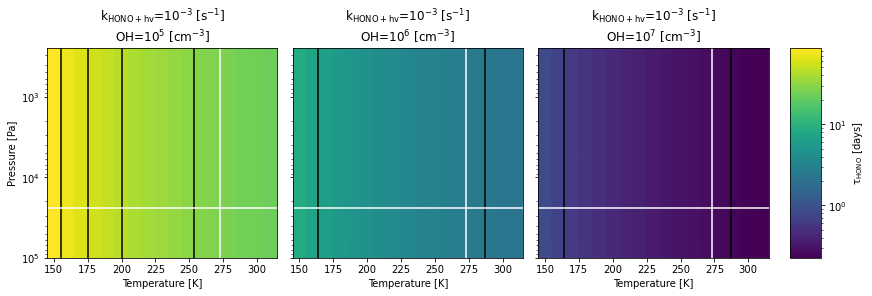

In [72]:
fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 4),
    facecolor="white",
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

common_min = np.min([tau_hono[0, ...].min(), tau_hono[1, ...].min(), tau_hono[2, ...].min()])
common_max = np.max([tau_hono[0, ...].max(), tau_hono[1, ...].max(), tau_hono[2, ...].max()])
print(common_min, common_max)

logdata = True
if logdata:
    kwargs = {"norm": colors.LogNorm(vmin=common_min, vmax=common_max), "shading": "auto"}
else:
    kwargs = {"vmin": common_min, "vmax": common_max, "shading": "auto"}

p0 = axes[0].pcolormesh(temp_range, pres_range, tau_hono[0, ...], **kwargs)
p1 = axes[1].pcolormesh(temp_range, pres_range, tau_hono[1, ...], **kwargs)
p2 = axes[2].pcolormesh(temp_range, pres_range, tau_hono[2, ...], **kwargs)

axes[0].contour(temp_range, pres_range, tau_hono[0, ...], levels=[30,45,60,80], colors='k')
axes[1].contour(temp_range, pres_range, tau_hono[1, ...], levels=[2.5,7], colors='k')
axes[2].contour(temp_range, pres_range, tau_hono[2, ...], levels=[0.25,0.7], colors='k')

fig.colorbar(p0, ax=axes, orientation="vertical", label="$\\tau_{HONO}$ [days]")

axes[0].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^5$ [$cm^{-3}$]")
axes[1].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^6$ [$cm^{-3}$]")
axes[2].set_title("$k_{HONO+hv}$=$10^{-3}$ [$s^{-1}]$\nOH=$10^7$ [$cm^{-3}$]")
axes[0].set_ylabel("Pressure [Pa]")  # if ax.get_subplotspec().is_first_col():

for ax in axes.flatten():
    ax.set_xlabel(u"Temperature [K]")
    ax.set_yscale("log")
    ax.set_ylim(1e5, 250)
    ax.axvline(x=273, color="w")
    ax.axhline(y=23800, color="w")  # 10 km

In [65]:
tau_hono[1, ...].min(), tau_hono[1, ...].max(),

(2.2624773070775235, 8.657238974409525)